EDA:

Lets's start by loading in dataset and taking a look at it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score


import eda_utils as eda
import models as model

housing = pd.read_csv('Ames_HousePrice.csv', index_col = 0)

housing_without_log = housing.copy()


housing.head()


,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [2]:
housing.shape

(2580, 81)

In [3]:
housing.columns


Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

Right off the bat, the following columns stand out as potential feature candidates in determining the sale price:

1. 'OverallQual' Overall quality of the house
2. 'OverallCond' Overall condition of the house
3. 'GrLivArea' Gross Living Area

Before we visualize the relationship between the Sale Price and its features, lets look at the 'SalePrice' itself. 

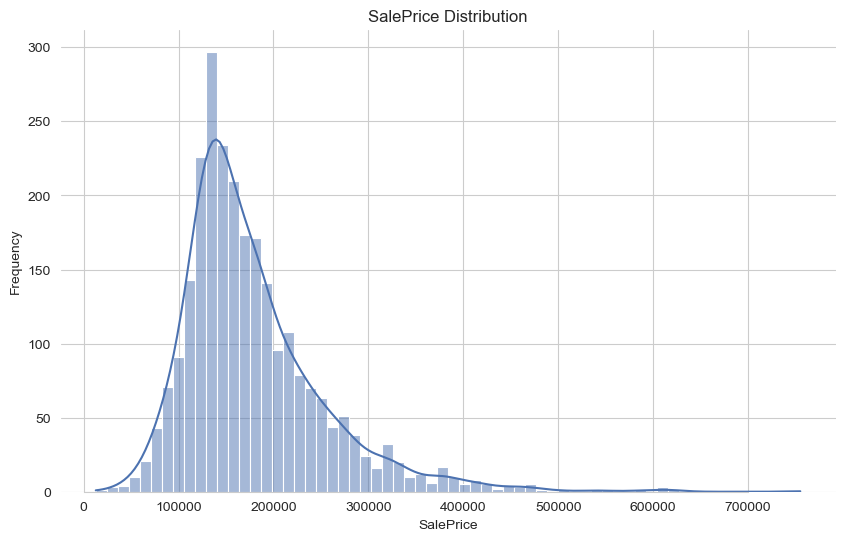

In [4]:
sns.set_style("whitegrid")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(housing['SalePrice'], kde = True, color = "b")
ax.set(title = "SalePrice Distribution",
       xlabel = "SalePrice",
       ylabel = "Frequency")
sns.despine(trim = True, left = True)
plt.show() 



As we can see, the distribution is skewed to the right. Let's normalize this to help our ML models perform better. We will apply a log transformation to fix the skew.

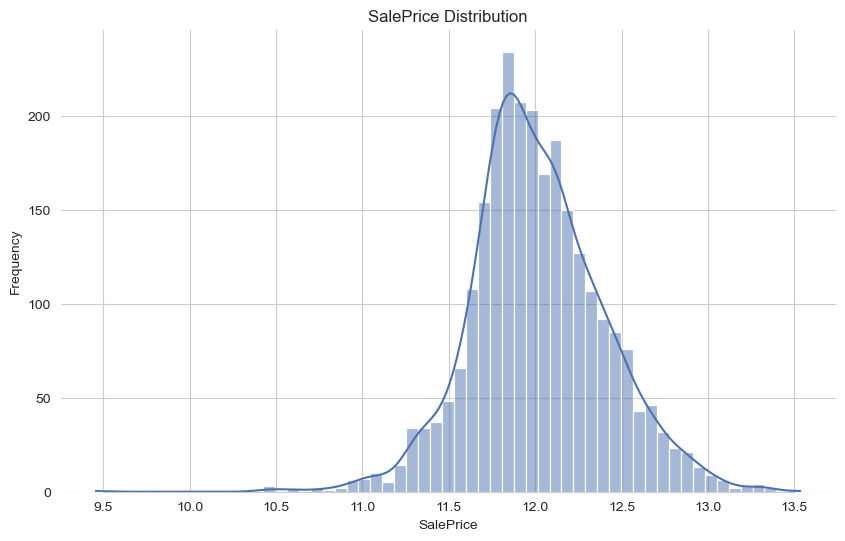

In [5]:
housing['SalePrice'] = np.log(housing['SalePrice'])
sns.set_style("whitegrid")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(housing['SalePrice'], kde = True, color = "b")
ax.set(title = "SalePrice Distribution",
       xlabel = "SalePrice",
       ylabel = "Frequency")
sns.despine(trim = True, left = True)
plt.show() 

Let's look at the relationship between the Overall Quality of the home and its Sale Price

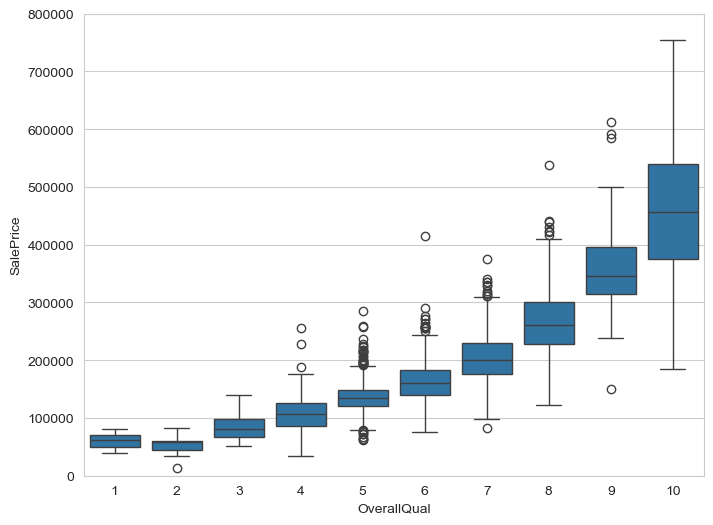

In [6]:
#Creating a box plot with OverallQual and Sale Price
data = pd.concat([housing_without_log['SalePrice'], housing_without_log['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=housing_without_log['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

It seems like Overall Quality is directly related to Sale Price with a positive correlation, now lets do the same over Overall Condition

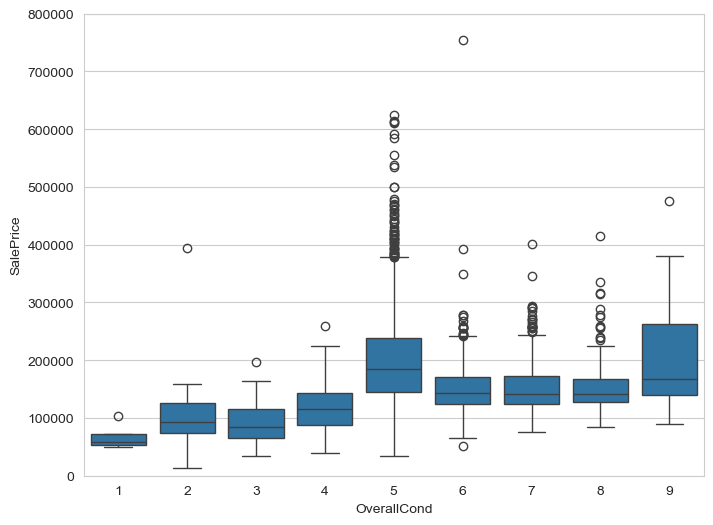

In [7]:
#Creating a box plot with OverallCond and Sale Price
data = pd.concat([housing_without_log['SalePrice'], housing_without_log['OverallCond']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=housing_without_log['OverallCond'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Hmmmm, not as correlated as Overall Quality. Let's

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

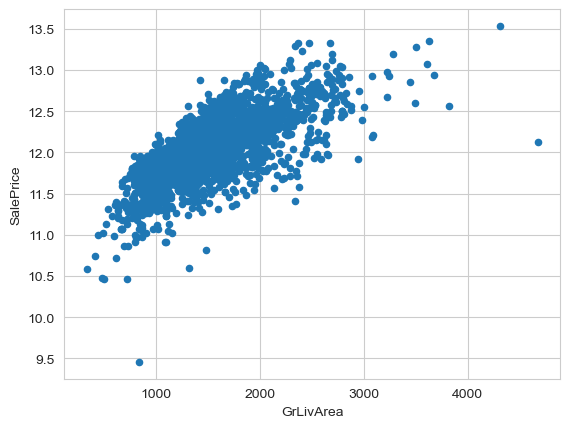

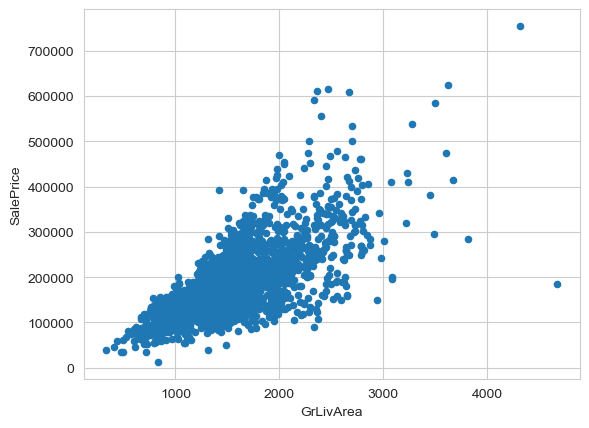

In [8]:
housing[['GrLivArea', 'SalePrice']].plot(kind='scatter', x='GrLivArea', y='SalePrice')
housing_without_log[['GrLivArea', 'SalePrice']].plot(kind='scatter', x='GrLivArea', y='SalePrice')

Seems like a pretty linear relationship with the Gross Living Area and Sale Price.

Let's make a correlation matrix heatmap with the rest of the features.

To make sure the heatmap is fed only numeric values, lets filter the dataset for numerics only before creating heatmap. 



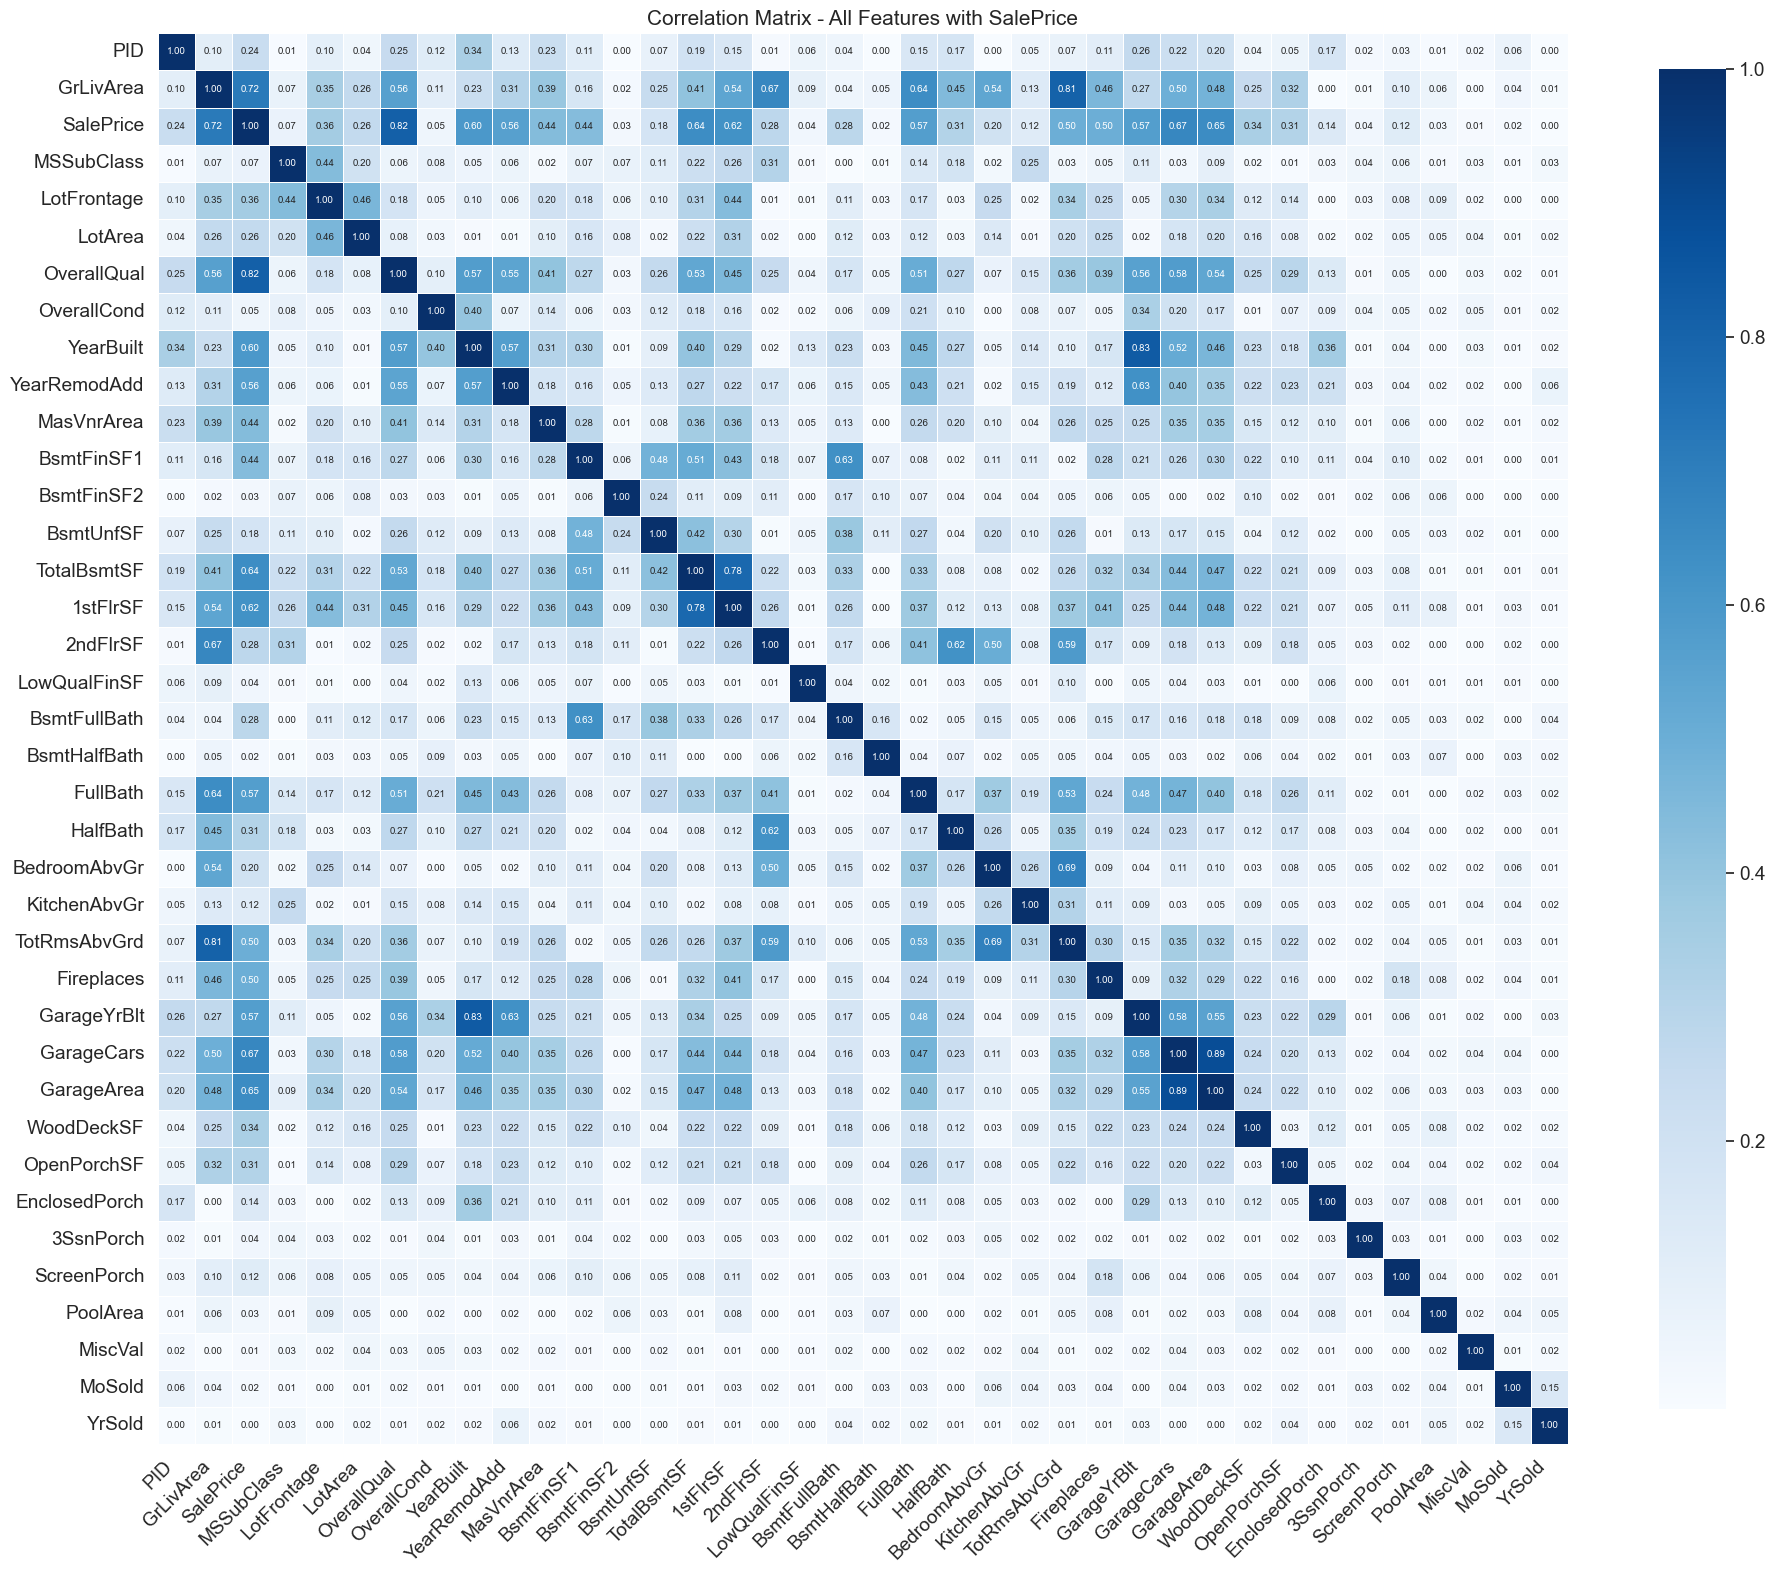

In [9]:
# Get the column names of all numeric data
numeric_columns = housing.select_dtypes(include = 'number').columns

# Plot a correlation matrix heatmap of numeric data
eda.plot_corr_matrix(housing[numeric_columns], 'SalePrice')

It seems like only a small subset of columns are having a large impact on our 'SalePrice' Let's narrow it down a bit for a clearer picture.

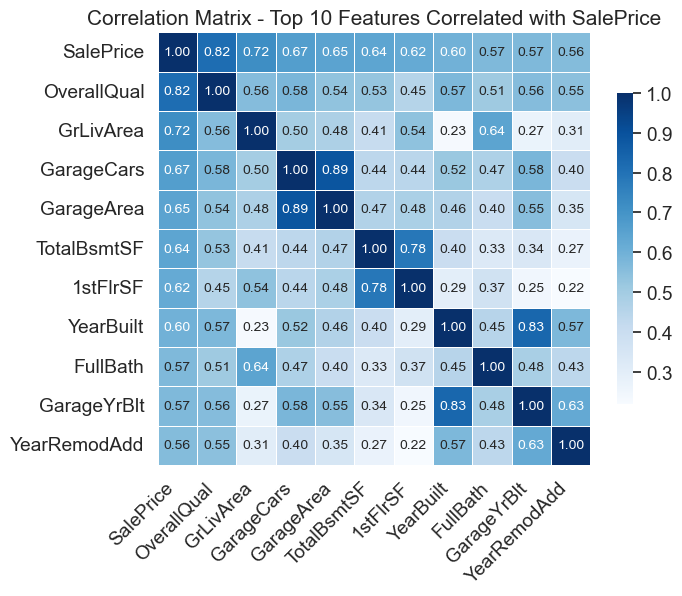

In [10]:
# Lets look at the top 20 features
eda.plot_corr_matrix(housing[numeric_columns], 'SalePrice', 11)

In [11]:
categorical_cols = housing.select_dtypes(include='object')
categorical_cols.shape[1]


43

In [12]:
numeric_cols = housing.select_dtypes(include = 'number')
numeric_cols.shape[1]

38

In [13]:
# Display number of missing values (NaN) for each column
total = housing.isnull().sum().sort_values(ascending=False)
percent = (housing.isnull().sum()/housing.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]
missing_data.head(10)


,Total,Percent
PoolQC,2571,0.996512
MiscFeature,2483,0.962403
Alley,2412,0.934884
Fence,2055,0.796512
MasVnrType,1573,0.609690
FireplaceQu,1241,0.481008
LotFrontage,462,0.179070
GarageQual,129,0.050000
GarageFinish,129,0.050000
GarageYrBlt,129,0.050000


Seems to be a lot of missing values in the dataset. Let's look further down the list to find them all.

In [14]:
missing_data.head(30)


,Total,Percent
PoolQC,2571,0.996512
MiscFeature,2483,0.962403
Alley,2412,0.934884
Fence,2055,0.796512
MasVnrType,1573,0.609690
FireplaceQu,1241,0.481008
LotFrontage,462,0.179070
GarageQual,129,0.050000
GarageFinish,129,0.050000
GarageYrBlt,129,0.050000


There are 27 columns columns with missing data values. I included percentage of missing values to see which columns are worth keeping or deleting. Let's split them up by Categorical and Numeric data.

In [15]:

numeric_cols = housing.select_dtypes(include = 'number').columns


numeric_total = housing[numeric_cols].isnull().sum().sort_values(ascending=False)
numeric_percent = (housing[numeric_cols].isnull().sum() / housing[numeric_cols].isnull().count()).sort_values(ascending=False)

numeric_missing_data = pd.concat([numeric_total, numeric_percent], axis=1, keys=['Total', 'Percent'])

numeric_missing_data = numeric_missing_data[numeric_missing_data['Total'] > 0]



numeric_missing_data.head(11)

,Total,Percent
LotFrontage,462,0.179070
GarageYrBlt,129,0.050000
MasVnrArea,14,0.005426
BsmtHalfBath,2,0.000775
BsmtFullBath,2,0.000775
GarageCars,1,0.000388
GarageArea,1,0.000388
TotalBsmtSF,1,0.000388
BsmtUnfSF,1,0.000388
BsmtFinSF2,1,0.000388


In [16]:
categorical_cols = housing.select_dtypes(include='object').columns

categorical_total = housing[categorical_cols].isnull().sum().sort_values(ascending=False)
categorical_percent = (housing[categorical_cols].isnull().sum() / housing[categorical_cols].isnull().count()).sort_values(ascending=False)

categorical_missing_data = pd.concat([categorical_total, categorical_percent], axis=1, keys=['Total', 'Percent'])

categorical_missing_data.head(16)


,Total,Percent
PoolQC,2571,0.996512
MiscFeature,2483,0.962403
Alley,2412,0.934884
Fence,2055,0.796512
MasVnrType,1573,0.609690
FireplaceQu,1241,0.481008
GarageCond,129,0.050000
GarageQual,129,0.050000
GarageFinish,129,0.050000
GarageType,127,0.049225


Luckily, we have a data description file which tells us that most of the Categorical features with missing values (NA) have a meaning for when the value is missing, which will allow us to assign relevant values to them. As for the numeric columns, the Garage columns can be be set to 0 as it means the house has no garage, same concept with the Basement columns. For the 'LotFrontage' column, we infer from the data description that this column is heavily influenced by the Neighborhood its belongs to. This can allow us to group by neighborhood and fill with median values from the specific neighborhood.

In [17]:
clean_data = eda.impute_missing_data(housing)
clean_data_without_log = eda.impute_missing_data(housing_without_log)

# Get total missing values and percentage for each column
total = clean_data.isnull().sum().sort_values(ascending=False)
percent = (clean_data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)

# Combine into a DataFrame
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# Show only columns that still have missing values (Total > 0)
print("\nRemaining missing values:")
print(missing_data[missing_data['Total'] > 0])


Remaining missing values:
Empty DataFrame
Columns: [Total, Percent]
Index: []


Our dataset now has 0 missing values! Let's see what our Correlation Matrix heatmap looks like now with the clean dataset.

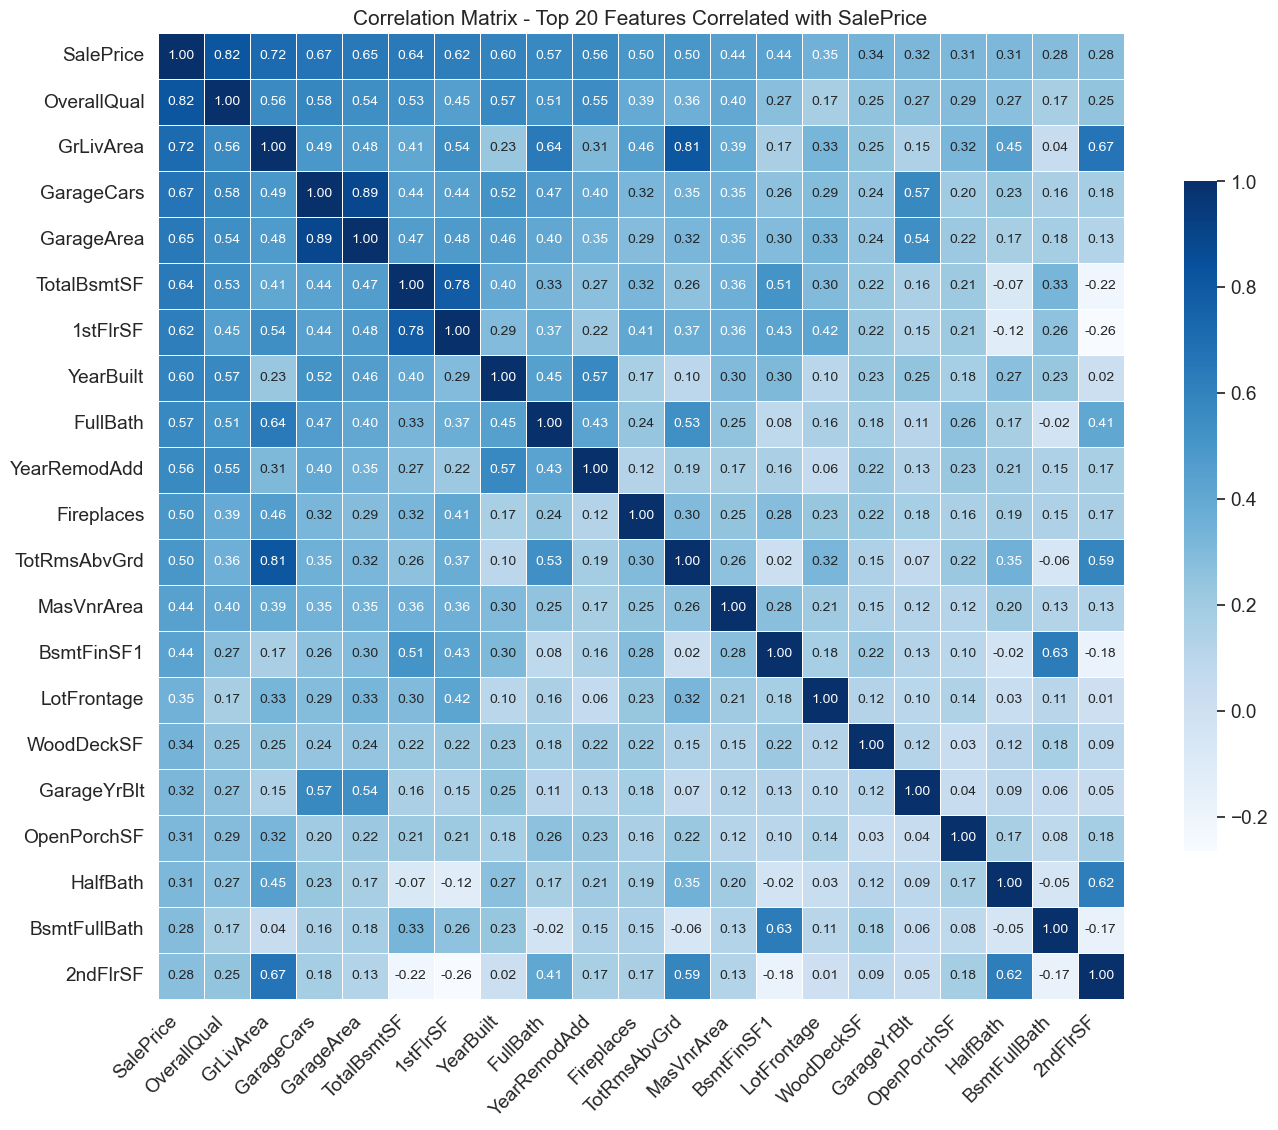

In [18]:
eda.plot_corr_matrix(clean_data[numeric_columns], 'SalePrice', 21)


Let's now use a Random Forest Regressor to see determine our most important features.

Mean R² Score: 0.891

Top 10 Most Important Features:
        Feature  Importance
5   OverallQual    0.552338
1     GrLivArea    0.141167
14     1stFlrSF    0.056485
13  TotalBsmtSF    0.042274
10   BsmtFinSF1    0.024890
27   GarageArea    0.024154
4       LotArea    0.012212
15     2ndFlrSF    0.010094
7     YearBuilt    0.009809
19     FullBath    0.008177


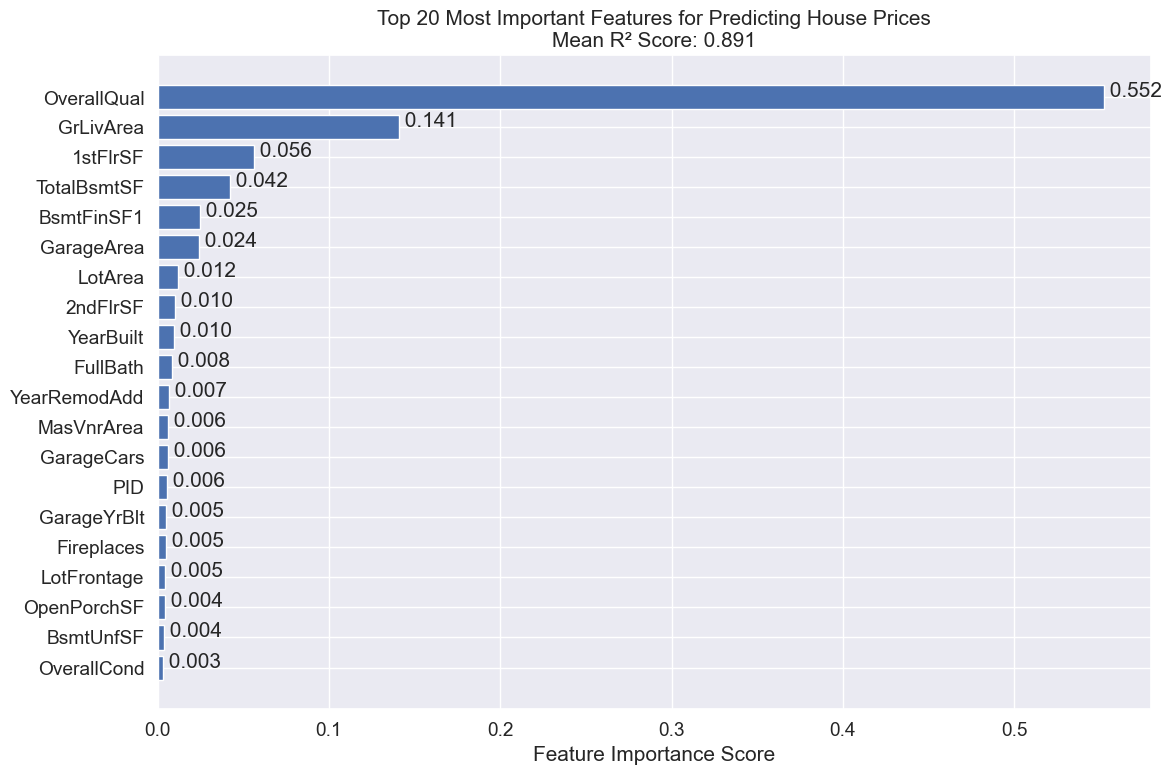

In [19]:
feature_importances, r2_score = model.random_forest_feature_selection(
    data=clean_data_without_log,
    target_column='SalePrice'
)

# Display results
print(f"Mean R² Score: {r2_score:.3f}")
print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# Visualize results
model.plot_feature_importance(feature_importances, r2_score)

In [20]:
top_features = feature_importances['Feature'].head(20).tolist()
X = clean_data_without_log[top_features]
y = clean_data_without_log['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training dataset
train_data = X_train.copy()
train_data['SalePrice'] = y_train

# Create test dataset
test_data = X_test.copy()
test_data['SalePrice'] = y_test


# Test Extra Trees training
et_results = model.extra_trees_train_model(
    data=train_data,
    target_column='SalePrice',
    features=top_features
)

# Print basic results
print("\nExtra Trees Model Performance:")
print(f"R² Score: {et_results['scores']['mean_r2']:.3f} (±{et_results['scores']['std_r2']:.3f})")
print(f"MSE: {et_results['scores']['mean_mse']:.3f} (±{et_results['scores']['std_mse']:.3f})")
print(f"MAE: {et_results['scores']['mean_mae']:.3f} (±{et_results['scores']['std_mae']:.3f})")


Extra Trees Model Performance:
R² Score: 0.890 (±0.041)
MSE: 582408643.557 (±197078144.079)
MAE: 14532.271 (±680.384)


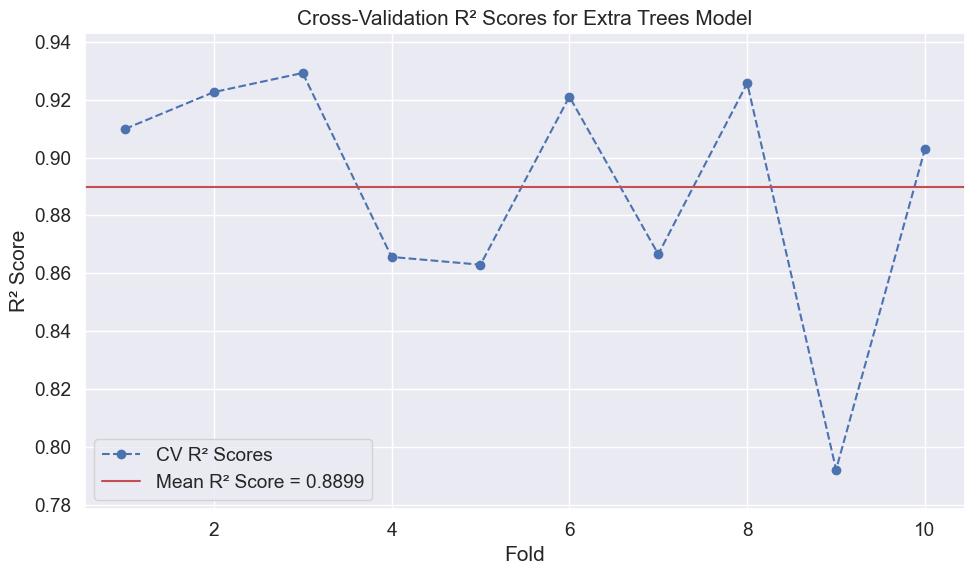


Cross-validation Results:
R² Score: 0.890 (±0.041)
MSE: 582408643.557 (±197078144.079)
MAE: 14532.271 (±680.384)


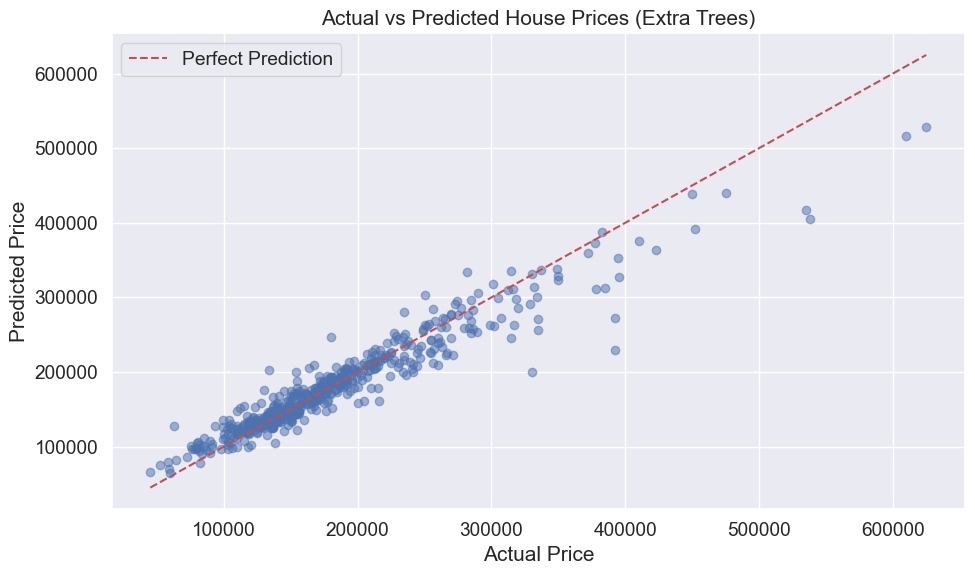


Prediction Summary:
Mean Absolute Error: $15,156.02
Mean Error: $1,467.30
Error Standard Deviation: $24,009.99


In [21]:
# After training your Extra Trees model
model.plot_et_cv_results(et_results['fold_scores'], et_results['scores'])
et_predictions = model.et_make_predictions(
    model=et_results['model'],
    data=test_data,
    features=top_features,
    target_column='SalePrice',
    log_transformed=False
)

In [22]:

catboost_results = model.catboost_train_model(
    data=train_data,
    target_column='SalePrice',
    features=top_features
)

# Print basic results
print("\nCatBoost Model Performance:")
print(f"R² Score: {catboost_results['scores']['mean_r2']:.3f} (±{catboost_results['scores']['std_r2']:.3f})")
print(f"MSE: {catboost_results['scores']['mean_mse']:.3f} (±{catboost_results['scores']['std_mse']:.3f})")
print(f"MAE: {catboost_results['scores']['mean_mae']:.3f} (±{catboost_results['scores']['std_mae']:.3f})")


CatBoost Model Performance:
R² Score: 0.901 (±0.035)
MSE: 520304895.163 (±157609830.222)
MAE: 14568.531 (±1064.475)


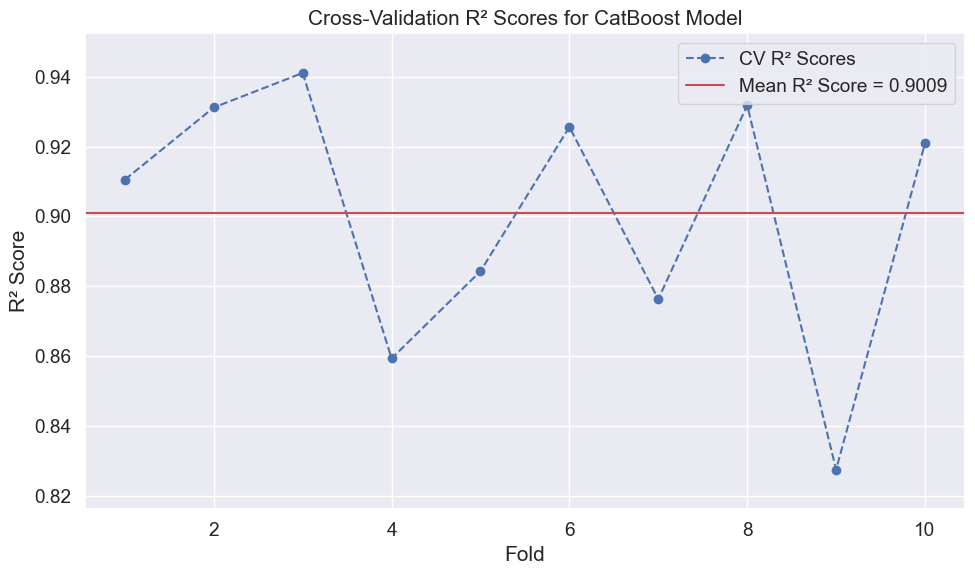


Cross-validation Results:
R² Score: 0.901 (±0.035)
MSE: 520304895.163 (±157609830.222)
MAE: 14568.531 (±1064.475)


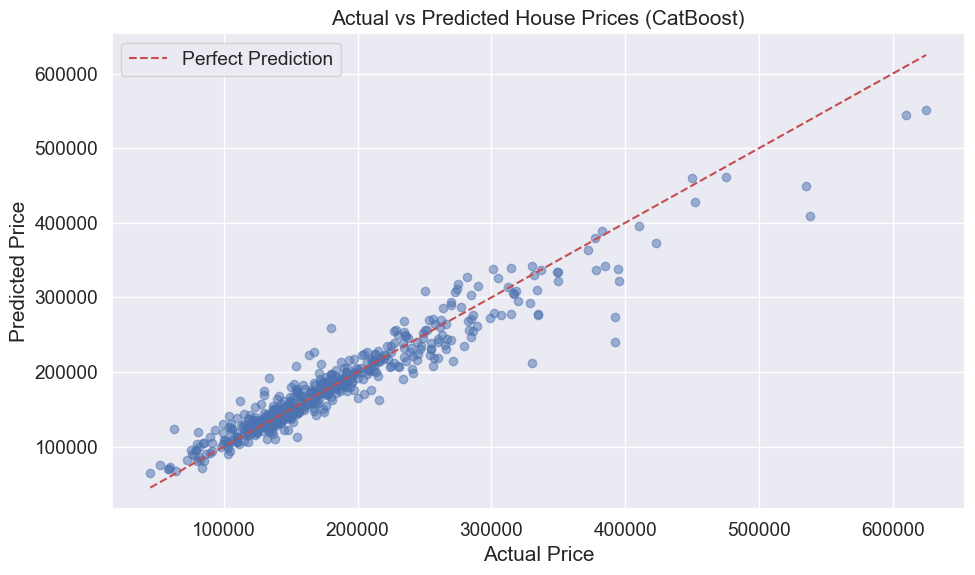


Prediction Summary:
Mean Absolute Error: $14,494.24
Mean Error: $711.57
Error Standard Deviation: $22,389.48


In [23]:
# After training your CatBoost model
model.plot_catboost_cv_results(catboost_results['fold_scores'], catboost_results['scores'])
catboost_predictions = model.catboost_make_predictions(
    model=catboost_results['model'],
    data=test_data,
    features=top_features,
    target_column='SalePrice',
    log_transformed=False
)

In [24]:
# First, train the model using your cleaned data and top features
lgb_results = model.lgb_train_model(
    data=train_data,
    target_column='SalePrice',
    features=top_features
)
# Print the performance metrics
print("\nLightGBM Model Performance:")
print(f"R² Score: {lgb_results['scores']['mean_r2']:.3f} (±{lgb_results['scores']['std_r2']:.3f})")
print(f"MSE: {lgb_results['scores']['mean_mse']:.3f} (±{lgb_results['scores']['std_mse']:.3f})")
print(f"MAE: {lgb_results['scores']['mean_mae']:.3f} (±{lgb_results['scores']['std_mae']:.3f})")




LightGBM Model Performance:
R² Score: 0.888 (±0.053)
MSE: 582439367.217 (±216573787.428)
MAE: 14012.495 (±587.895)



LightGBM Model Performance:
R² Score: 0.888 (±0.053)
MSE: 582439367.217 (±216573787.428)
MAE: 14012.495 (±587.895)


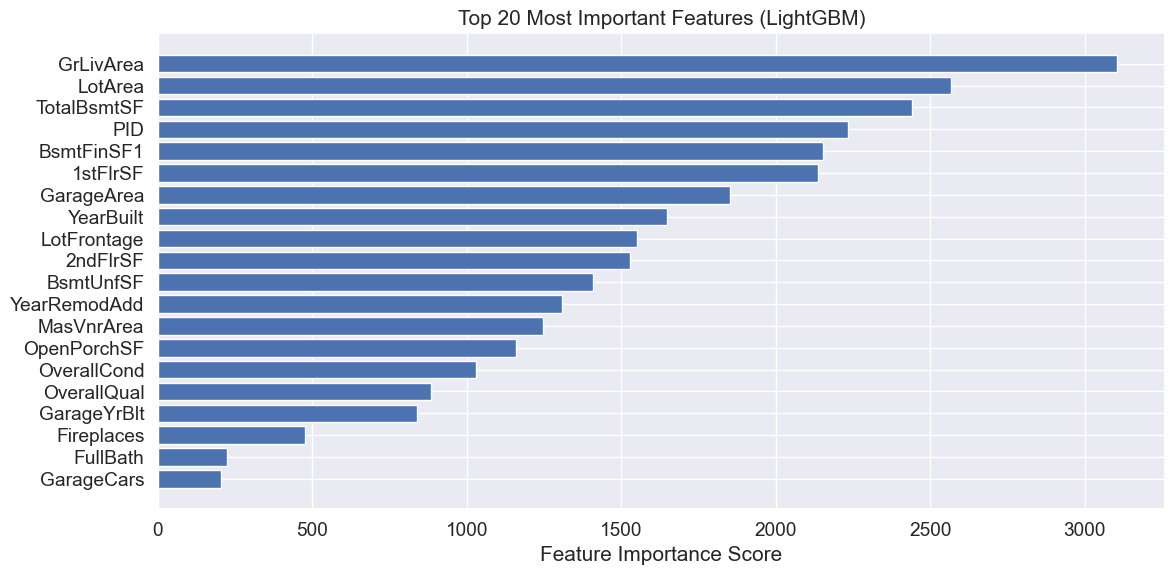

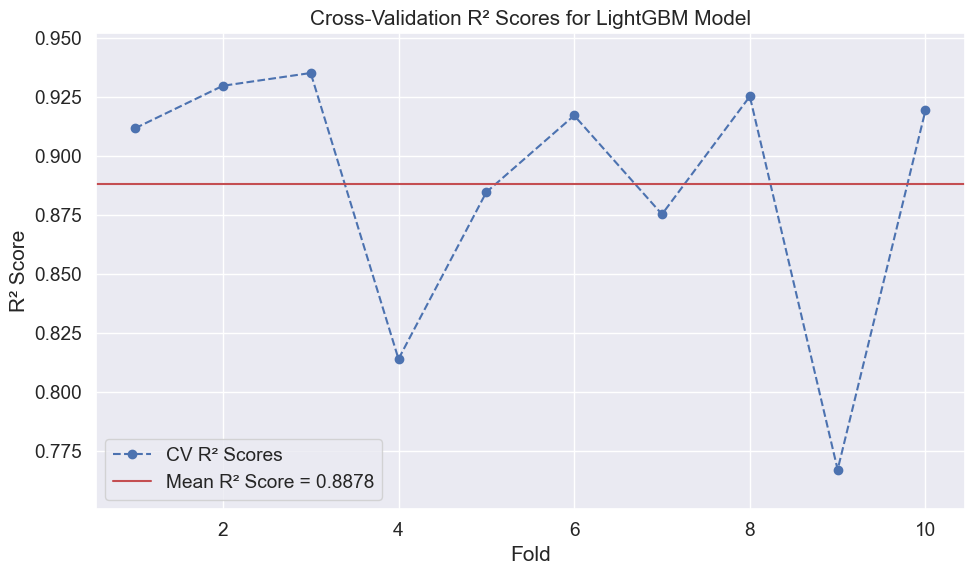

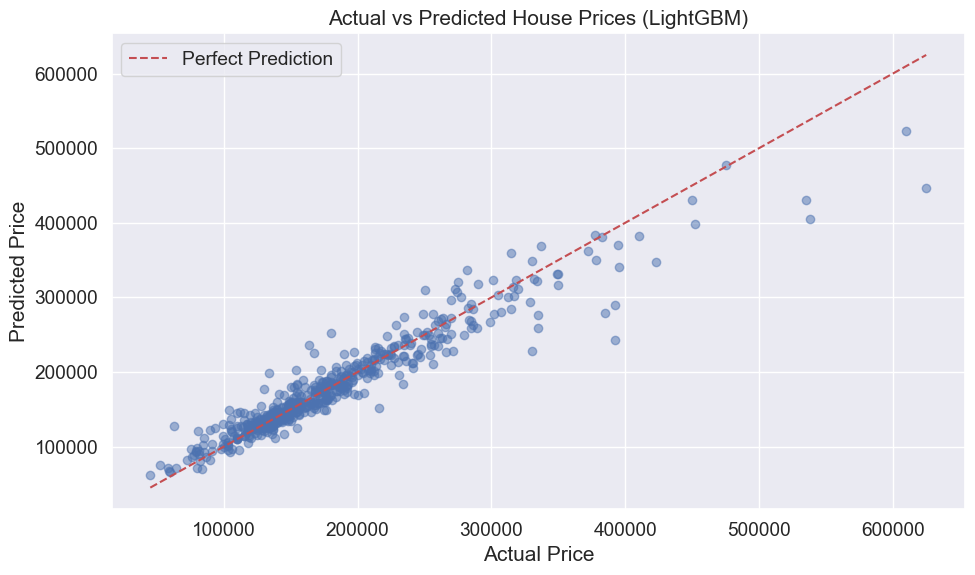


Prediction Summary:
Mean Absolute Error: $14,448.59
Mean Error: $1,093.64
Error Standard Deviation: $23,727.56


In [25]:
model.plot_lgb_results(lgb_results)
model.plot_lgb_cv_results(lgb_results['fold_scores'], lgb_results['scores'])
lgb_predictions = model.lgb_make_predictions(
    model=lgb_results['model'],
    data=test_data,
    features=top_features,
    target_column='SalePrice',
    log_transformed=False
)

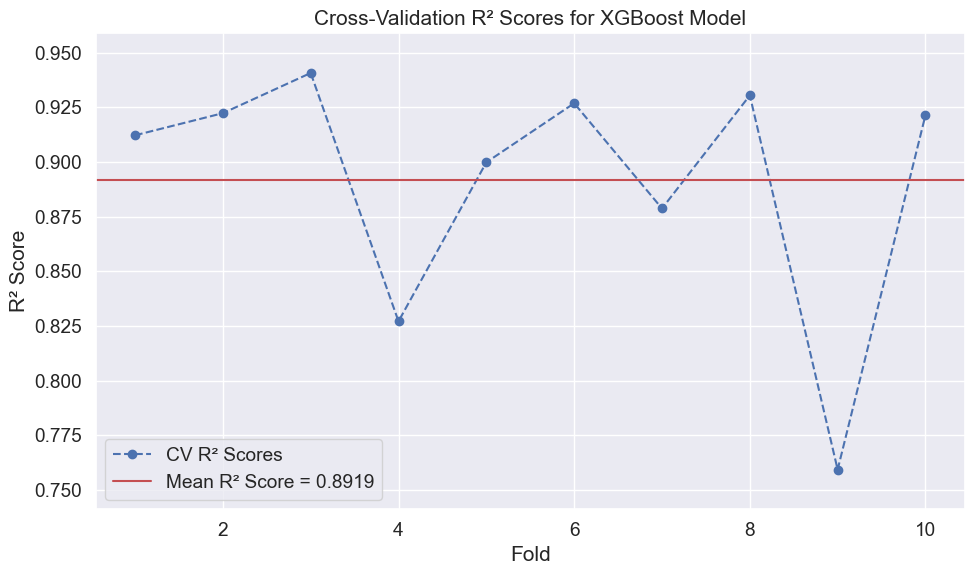


Cross-validation Results:
R² Score: 0.892 (±0.054)
MSE: 556341055.765 (±216328674.286)
MAE: 14022.009 (±514.939)


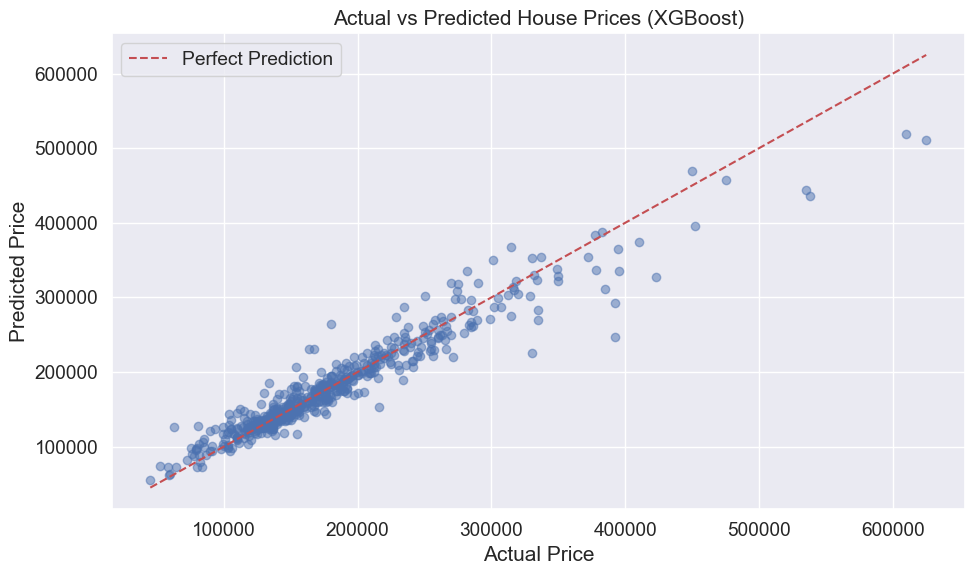


Prediction Summary:
Mean Absolute Error: $14,213.11
Mean Error: $515.27
Error Standard Deviation: $22,511.21


In [26]:

xgb_results = model.xgb_train_model(
    data=train_data,
    target_column='SalePrice',
    features=top_features
)
# Plot results
model.plot_xgb_cv_results(xgb_results['fold_scores'], xgb_results['scores'])

# Make predictions using the trained model
xgb_predictions = model.xgb_make_predictions(
    model=xgb_results['model'],
    data=test_data,
    features=top_features,
    target_column='SalePrice',
    log_transformed=False
)

Now lets use these features and train our Random Forest model using 10 fold Cross validation.

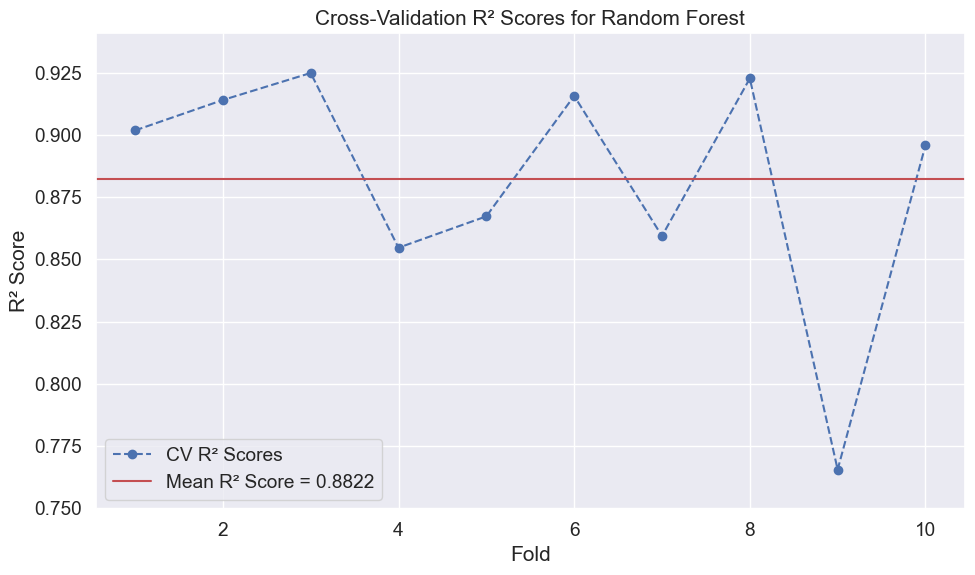


Cross-validation Results:
R² Score: 0.882 (±0.046)
MSE: 619230266.110 (±205871870.567)
MAE: 14978.775 (±629.562)


In [27]:
rf_results = model.random_forest_regressor(
    data=train_data,
    target_column='SalePrice',
    features=top_features
)

# Plot cross-validation results
model.plot_cv_results(rf_results['fold_scores'], rf_results['scores'])

Not bad! Let's see the predicitions.

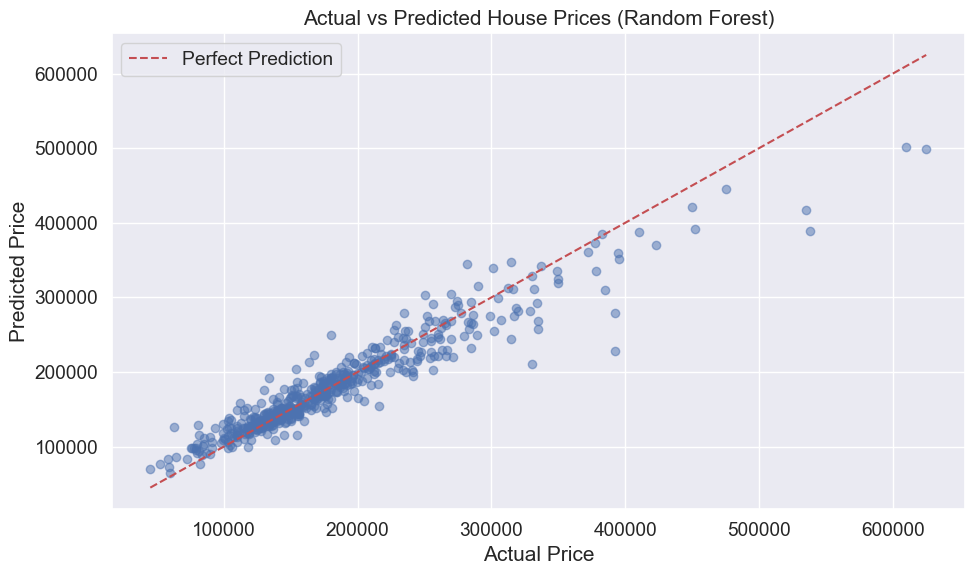


Prediction Summary:
Mean Absolute Error: $15,755.83
Mean Error: $1,416.13
Error Standard Deviation: $24,961.95


In [28]:
rf_predictions = model.rf_make_predictions(
    model=rf_results['model'],  # Now accessing the model from the dictionary
    data=test_data,
    features=top_features,
    target_column='SalePrice',
    log_transformed=False
)


Finally, Let's Compare all 5 models.


Model Performance Comparison:

XGBoost:
MAE: $14,213.11
Mean Error: $515.27
Std Dev: $22,511.21
R² Score: 0.9177

LightGBM:
MAE: $14,448.59
Mean Error: $1,093.64
Std Dev: $23,727.56
R² Score: 0.9085

CatBoost:
MAE: $14,494.24
Mean Error: $711.57
Std Dev: $22,389.48
R² Score: 0.9186

Extra Trees:
MAE: $15,156.02
Mean Error: $1,467.30
Std Dev: $24,009.99
R² Score: 0.9061

Random Forest:
MAE: $15,755.83
Mean Error: $1,416.13
Std Dev: $24,961.95
R² Score: 0.8986


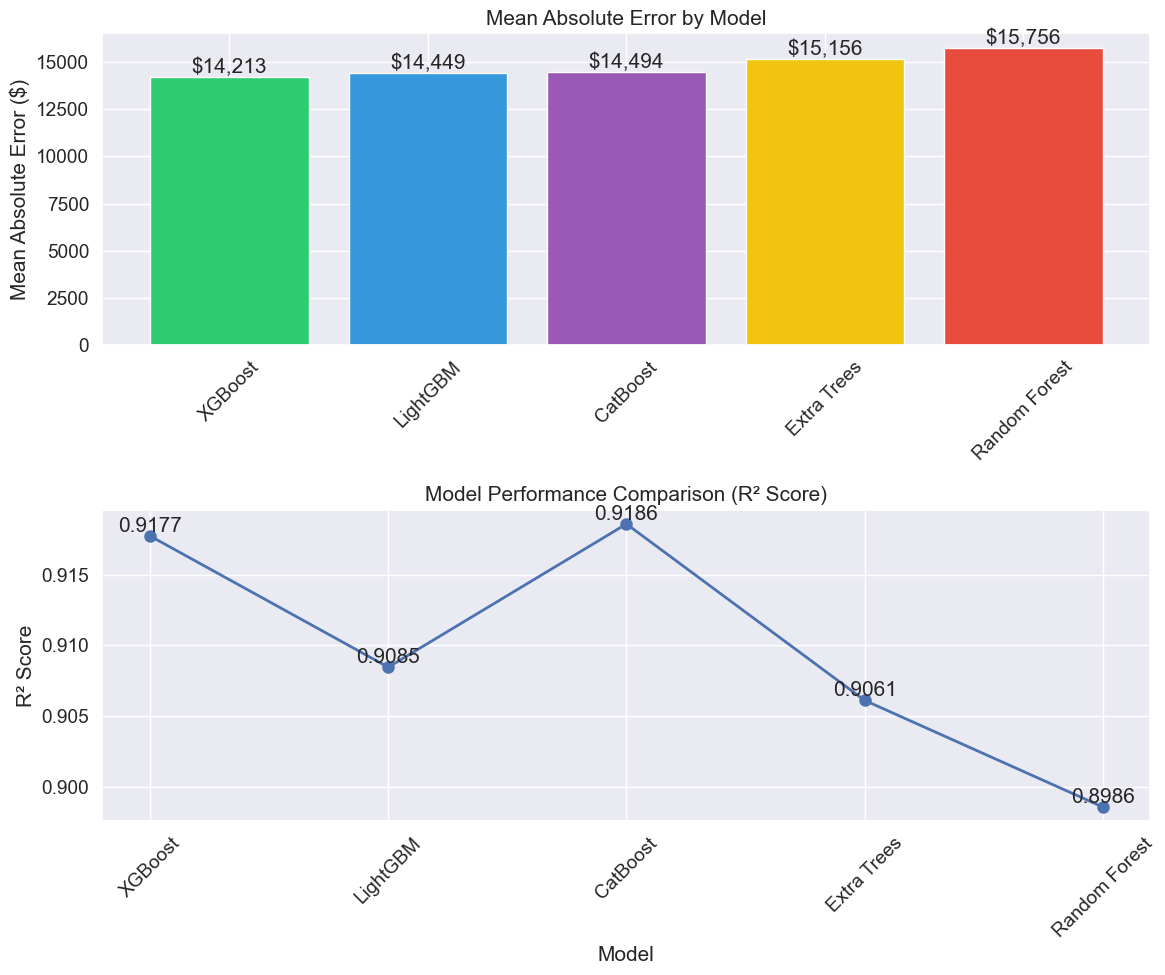

In [29]:

model_results = {
    'XGBoost': xgb_predictions,
    'LightGBM': lgb_predictions,
    'CatBoost': catboost_predictions,
    'Extra Trees': et_predictions,
    'Random Forest': rf_predictions
}


comparison = model.compare_models(model_results)

Alright, im going to sleep